# Getting set up

In [20]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from sentence_transformers import SentenceTransformer

# 1. Load variables from .env file
load_dotenv()

# 2. Get the token securely
hf_token = os.getenv("HF_TOKEN")

# 3. Authenticate
login(token=hf_token)

# 4. Load the model (with trust_remote_code if needed for Gemma)
model = SentenceTransformer("google/embeddinggemma-300m", trust_remote_code=True)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

from sentence_transformers import SentenceTransformer

# Download from the 🤗 Hub
model = SentenceTransformer("google/embeddinggemma-300m", device = "cuda")


# Loading and embedding data

In [ ]:
data = pd.read_csv("data/samples/balanced_sample_20000.csv",
                   on_bad_lines="skip")

X_train, X_test, y_train, y_test = train_test_split(
    data[["selftext"]],
    data["target"],
    test_size=0.1,
    random_state=42,
    stratify=data["target"]
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (14392, 1)
X_val shape: (3599, 1)
X_test shape: (1999, 1)


In [23]:
def gemma_encode(model, X:pd.DataFrame, embdedding_size=768):
    print(f"Shape of input: {X.shape}")
    print(f"Shape of output: {(X.shape[0],embdedding_size)}")


    embX = model.encode(X.iloc[:,0].to_list(),
                        show_progress_bar=True)
    return embX
#(172, 768)

In [24]:
embX_train = gemma_encode(model=model, X=X_train)
#(172, 768)

Shape of input: (14392, 1)
Shape of output: (14392, 768)


Batches:   0%|          | 0/450 [00:00<?, ?it/s]

In [25]:
embX_val = gemma_encode(model=model, X=X_val)
#(172, 768)

Shape of input: (3599, 1)
Shape of output: (3599, 768)


Batches:   0%|          | 0/113 [00:00<?, ?it/s]

### Truncating Embeddings using Matryoshka Representation Learning (MRL)

As per the model card, we can achieve smaller embedding dimensions by truncating the 768-dimensional output and then re-normalizing. Let's define a function to do this.

In [50]:
import numpy as np

def truncate_and_normalize_embeddings(embeddings, target_dim):
    """
    Truncates embeddings to a target dimension and re-normalizes them.
    Assumes the input embeddings are already normalized (e.g., L2-normalized).
    """
    if target_dim > embeddings.shape[1]:
        raise ValueError(f"Target dimension {target_dim} cannot be greater than current dimension {embeddings.shape[1]}")

    truncated_embeddings = embeddings[:, :target_dim]
    # Re-normalize the truncated embeddings to maintain properties
    truncated_embeddings = truncated_embeddings / np.linalg.norm(truncated_embeddings, axis=1, keepdims=True)
    return truncated_embeddings

print("Truncation and re-normalization function defined.")

Truncation and re-normalization function defined.


Now, let's apply this to our `embX_train` embeddings to get a 256-dimensional representation.

In [53]:
target_embedding_dim = 256
embX_train_256 = truncate_and_normalize_embeddings(embX_train, target_embedding_dim)
embX_val_256 = truncate_and_normalize_embeddings(embX_val, target_embedding_dim)

print(f"Original embX_train shape: {embX_train.shape}")
print(f"Truncated embX_train_256 shape: {embX_train_256.shape}")

Original embX_train shape: (14392, 768)
Truncated embX_train_256 shape: (14392, 256)


# Modelling

## Logistic regression

logreg               precision    recall  f1-score   support

           0       0.62      0.61      0.62      1799
           1       0.62      0.62      0.62      1800

    accuracy                           0.62      3599
   macro avg       0.62      0.62      0.62      3599
weighted avg       0.62      0.62      0.62      3599



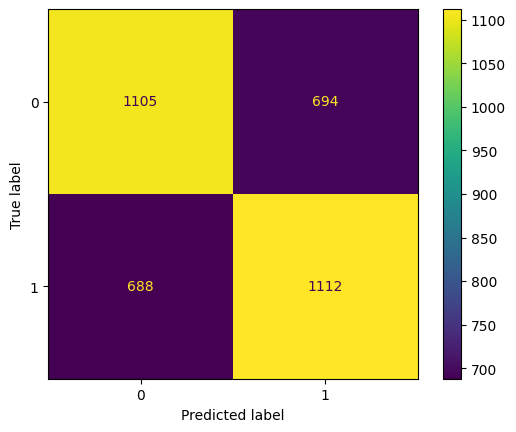

In [54]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(embX_train_256, y_train)
y_pred = logreg.predict(embX_val_256)

print("logreg",classification_report(y_true=y_val, y_pred=y_pred))

logreg_cm = confusion_matrix(y_true=y_val, y_pred=y_pred)
disp = ConfusionMatrixDisplay(logreg_cm)
disp.plot()
plt.show()

## Gradient boosted trees

In [55]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(
    n_iter_no_change=5, # Stop if no improvement for 1ions
    validation_fraction=0.1, # Use 10% of training data for validation
    # The actual validation set for early stopping will be `embX_val`, `y_val`
    # so we set n_iter_no_change and validation_fraction to enable it.
    # Note: scikit-learn's GBC doesn't directly take an external validati0 consecutive iteraton set for early stopping
    # but we can simulate it by setting a small validation_fraction and monitoring progress manually
    # or setting n_iter_no_change and letting it split internally.
    # For this demonstration, we'll enable the parameters that allow early stopping behavior.
)
gbc.fit(embX_train_256, y_train)
y_pred = gbc.predict(embX_val_256)

GBT_train_performance:               precision    recall  f1-score   support

           0       0.68      0.69      0.69      7196
           1       0.69      0.68      0.68      7196

    accuracy                           0.68     14392
   macro avg       0.68      0.68      0.68     14392
weighted avg       0.68      0.68      0.68     14392

GBT_validation_performance:               precision    recall  f1-score   support

           0       0.61      0.60      0.60      1799
           1       0.61      0.61      0.61      1800

    accuracy                           0.61      3599
   macro avg       0.61      0.61      0.61      3599
weighted avg       0.61      0.61      0.61      3599



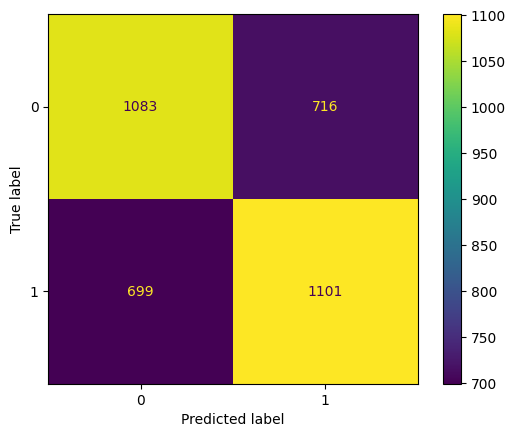

In [57]:
print("GBT_train_performance:",classification_report(y_true=y_train, y_pred=gbc.predict(embX_train_256)))
print("GBT_validation_performance:",classification_report(y_true=y_val, y_pred=y_pred))

gbt_cm = confusion_matrix(y_true=y_val, y_pred=y_pred)
disp = ConfusionMatrixDisplay(gbt_cm)
disp.plot()
plt.show()

In [58]:
print(gbc.get_params())

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': 5, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
